In [12]:
import numpy as np
import pandas as pd
import itertools
from trained_untrained_results_funcs import loop_through_datasets, find_best_layer
from plotting_functions import plot_across_subjects
from matplotlib import pyplot as plt

In [13]:
blank_models = ['pos', 'WN', 'gpt2xl']
fedorenko_models = ['WP', 'gpt2xl']
pereira_models = ['pos', 'WN', 'gpt2xl', 'glove']

model_combos_datasets = {'blank': blank_models, 'fedorenko': fedorenko_models, 'pereira': pereira_models}

def load_model_combinations(models, exp, dataset, fe, niter_combs=[1,1000], perf='out_of_sample_r2'):
    
    model_name = []
    model_perf = []
    num_models = 0
    
    for r in range(1, len(models) + 1):
        for combination in itertools.combinations(models, r):
            model_combined = '+'.join(combination)

            results = None
            for niter in niter_combs:
                try:
                    results = np.load(f'/data/LLMs/brainscore/results_{dataset}/{dataset}_trained-var-par{exp}{fe}_{model_combined}_{niter}{exp}.npz')[perf]
                    break
                except:
                    pass
                
            if results is not None:            
                model_perf.extend(results)
                model_name.extend(np.repeat(model_combined, len(results)))
                num_models += 1
                
    return model_perf, model_name, num_models           

In [14]:
def return_subjects_networks(dataset, exp):
    
    subjects = np.load(f"/data/LLMs/data_processed/{dataset}/dataset/subjects{exp}.npy", allow_pickle=True)
                
    try:
        network = np.load(f"/data/LLMs/data_processed/{dataset}/dataset/networks{exp}.npy", allow_pickle=True)
    except:
        network = np.repeat(['language'], len(subjects))

    return subjects, network

In [15]:
def filter_by_model(df, model_list):
    """
    Filters a DataFrame to include only rows where the Model column matches one of the models in the given list.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - model_list (list): A list of model names to keep.
    
    Returns:
    - pd.DataFrame: The filtered DataFrame.
    """
    if 'Model' not in df.columns:
        raise ValueError("The DataFrame does not contain a 'Model' column.")
    
    return df[df['Model'].isin(model_list)]

Clipping 0 values
Taking mean value across voxels with a participant


/home3/ebrahim2/miniconda3/envs/llm_brain/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Clipping 0 values
Taking mean value across voxels with a participant


/home3/ebrahim2/miniconda3/envs/llm_brain/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Clipping 0 values
Taking mean value across voxels with a participant


/home3/ebrahim2/miniconda3/envs/llm_brain/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


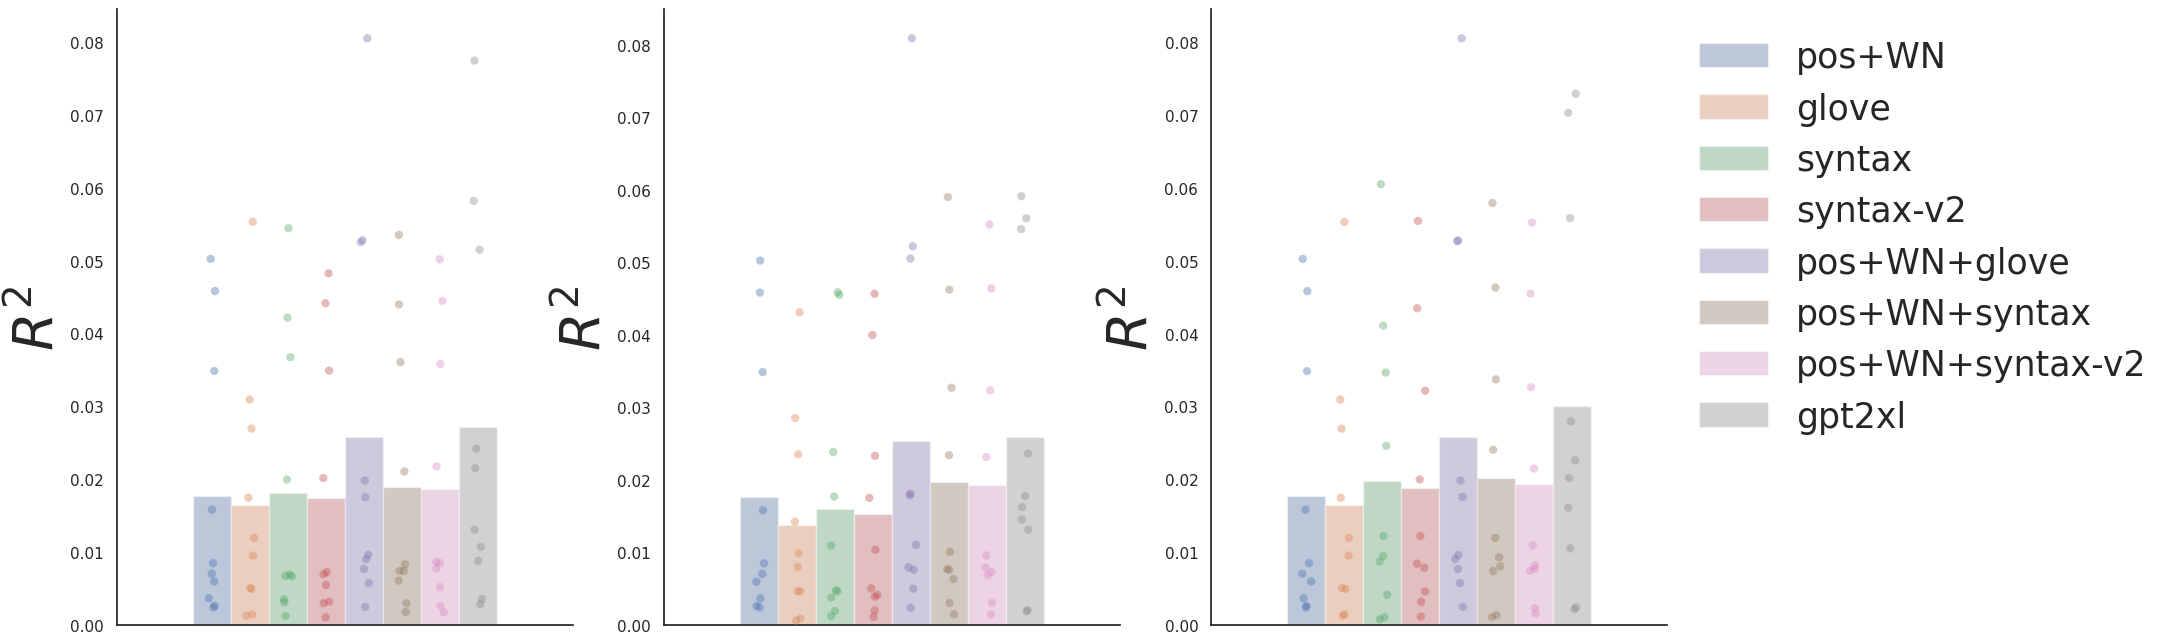

In [11]:
pereira_exp_counter = 0
c = 0

model_list_dict = {'pereira': ['pos+WN', 'glove', 'syntax', 'syntax-v2', 'pos+WN+glove', 'pos+WN+syntax', 'pos+WN+syntax-v2', 'gpt2xl'], 
                'fedorenko': ['WP', 'WP+gpt2xl', 'gpt2xl'], 
                'blank': ['pos+WN', 'gpt2xl', 'pos+WN+gpt2xl']}

for dataset in ['pereira']:
    
    fig, ax = plt.subplots(1,3,figsize=(20,8))
    
    if dataset == 'pereira':
        
        exp_arr = ['384', '243']
    else:
        exp_arr = ['']
        
    for c, fe in enumerate(['', '-mp', '-sp']):
        
        dataset_dict = {'perf':[], 'subjects': [], 'Network': [],  'Model': []}
        
        if dataset == 'pereira':
            dataset_dict['Exp'] = []
        
        for exp in exp_arr:
            
            if len(exp) > 0:
                exp = f"_{exp}"
            
            subjects, network = return_subjects_networks(dataset, exp)
            
            model_perf, model_name, num_models = load_model_combinations(model_combos_datasets[dataset], exp, 
                                                dataset, fe, niter_combs=[1,1000], perf='out_of_sample_r2')
            
            
            dataset_dict['perf'].extend(model_perf)
            dataset_dict['Model'].extend(model_name)
            dataset_dict['subjects'].extend(np.tile(subjects, num_models))
            dataset_dict['Network'].extend(np.tile(network, num_models))
            
            if dataset == 'pereira':
                
                lang_indices = np.argwhere(network=='language').squeeze()
                
                layer_perf_dict, best_layer, layer_perf_best  = find_best_layer(np.arange(49), noL2_str='', 
                exp=exp, resultsPath='/data/LLMs/brainscore/results_pereira/', subjects=subjects, 
                dataset='pereira', perf='out_of_sample_r2', 
                selected_network_indices = lang_indices, 
                feature_extraction = '', model_name=f'gpt2xl-syntax{fe}', 
                seed_number=None, 
                return_SE=False, niter=1)
                
                dataset_dict['perf'].extend(np.clip(layer_perf_best, 0, np.inf))
                dataset_dict['Model'].extend(np.repeat('Syntax', len(layer_perf_best)))
                dataset_dict['subjects'].extend(subjects)
                dataset_dict['Network'].extend(network)
                
                dataset_dict['Exp'].extend(np.repeat(exp, len(model_perf)+len(layer_perf_best)))
            
        
        dataset_dict = pd.DataFrame(dataset_dict)

        dataset_dict = filter_by_model(dataset_dict, model_list_dict[dataset])
        hue_order = model_list_dict[dataset]
            
        if c== 2:
            plot_legend = True
        else:
            plot_legend = False
    
        plot_across_subjects(dataset_dict.copy(), figurePath=f'/home3/ebrahim2/beyond-brainscore/analyze_results/figures_code/figures/new_figures/figure4/', dataset=dataset, 
                            selected_networks=['language'], ax_select=ax[c], saveName=dataset, clip_zero=True, plot_legend=plot_legend, 
                            hue_order=hue_order)
        
    plt.show()
    